#### Preparation
This project can use Weights & Biases for tracking metrics. Enabling this requires an account and api key, which can be set below. If this key is ommitted, metrics will not be pushed to Weights & Biases, but all analyses will work just fine.   

Weights & Biases can be installed using: `pip install wandb`.  

This notebook requires the execution of:
- `Data Exporation and Preprocessing` 

In [1]:
import os
# Optional: set your W&B api key below. Looks like: 7ol65g3j2rulhg3af4o7m8wma8d9isyu3myqkdb8 (example)
os.environ['WANDB_API_KEY'] = ''
os.environ['WANDB_PROJECT'] = 'particle_process_discriminator'

if os.environ['WANDB_API_KEY'] is not '':
    # login to W&B account
    res = os.system('wandb login {}'.format(os.environ['WANDB_API_KEY']))
    print("Logged in to Weights & Biases")

#### Initialize

In [2]:
# (basic) dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm as tqdm

# sklearn dependencies
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# tensorflow dependencies
from tensorflow.keras import datasets, layers, models, regularizers, backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding

if os.environ['WANDB_API_KEY'] is not '':
    import wandb
    from wandb.keras import WandbCallback

# import classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

MODEL_DIR = 'models'

In [3]:
# own dependencies
from helper import metrics, learn, select_features, load_data, cross_validation, ROC
from helper import make, save, make_args, build_architecture, train_net, train_args

In [4]:
# further settings
FIG_DIR = 'figures/'
plt.rcParams["figure.figsize"] = (10, 4.5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 14})
plt.rcParams["savefig.bbox"] = 'tight'

random_state = 576

In [5]:
def plot_accuracy_gain(acc, labels, baseline, fn=None, label_rotation=0):
    f, axes = plt.subplots(1, 1, figsize=(10, 5))
    ax = axes

    # calculate means and std. between trails
    means, stds = np.mean(acc, axis=-1), np.std(acc, axis=-1)
    ax.bar(range(len(labels)), height=means - means[baseline], yerr=stds, capsize=4)
    ax.axhline(0, color='k')
    ax.set_xticklabels(labels, rotation=label_rotation)
    ax.set_xticks(range(len(labels)))
    
    # Set xticks to percentage
    vals = ax.get_yticks()
    labels = ['{:,.1%}'.format(x) for x in vals]
    ax.set_yticklabels(labels)
    ax.set_ylabel("Validation accuracy gain")

    f.tight_layout()
    if fn is not None:
        f.savefig('{}/{}'.format(FIG_DIR, fn))
    plt.show()

# Particle Process Discriminator - Algorithm Selection

This notebook explores several classifiers to discriminate between signal (events with 4 top quarks) and background (events with a top and antitop quark). Exploratory data analysis is performed in `Data Exporation and Preprocessing`, the reader is refered there for an analysis of the problem.  

The dataset contains 100.000 samples, so for quick inference, ensembles of Decision Trees are considered. K-nearest Neighbours classifiers are too slow on inference.  

Specifically, the following methods are considered:
- Single Decision Tree
- A boosted ensemble of Decision Trees
- A bagged ensemble of Decision Trees
- A Random Forest classifier

Furthermore, a deep neural network is considered. This network can aliviate several limitations of Decision Trees, but requires more setup. A simple network is trained here, with more analysis provided in `Train Deep Neural Networks`.   

Finally, the tabular dataset is converted to images, with the azimuthal angle and pseudorapidity decoding for the pixel location. A simple network is trained here, with an extensive analysis of symmetries provided in `Train Convolutional Neural Networks`. 

# Compare sklearn classifiers with 5-fold cross validation
The following classifiers are considered: 
- Single Decision Tree
- A boosted ensemble of Decision Trees
- A bagged ensemble of Decision Trees
- A Random Forest classifier

The bagged ensemble of Decision Trees is configured in four ways:
- With Decision Trees of max. depth 4 or 8
- With either 50% of data and features, or with 75% of data and features 

All ensemble classifiers are trained with 100 estimators. 

In [6]:
# read train and validation data
data, features, target = load_data('data', trans='plain', norm='minmax')
print("Size of DataFrame: {}".format(data.shape))

Size of DataFrame: (100000, 248)


In [7]:
n_estimators = 100
criterion = 'entropy'  # seems like the natural choice for physical processes
n_jobs = -1  # number of processor cores to use (-1 to utilize all cores)
verbose = 1  # verbosity (1 = verbose, 0=silent)

classifier_options = [
    DecisionTreeClassifier(criterion=criterion),
    
    AdaBoostClassifier(DecisionTreeClassifier(criterion=criterion, max_depth=2), 
                       n_estimators=n_estimators),
    
    BaggingClassifier(DecisionTreeClassifier(criterion=criterion, max_depth=4), 
                      n_estimators=n_estimators, max_samples=0.5, max_features=0.5, 
                      n_jobs=n_jobs, verbose=verbose),
    
    BaggingClassifier(DecisionTreeClassifier(criterion=criterion, max_depth=8), 
                      n_estimators=n_estimators, max_samples=0.5, max_features=0.5, 
                      n_jobs=n_jobs, verbose=verbose),
    
    BaggingClassifier(DecisionTreeClassifier(criterion=criterion, max_depth=4), 
                      n_estimators=n_estimators, max_samples=0.75, max_features=0.75, 
                      n_jobs=n_jobs, verbose=verbose),
    
    BaggingClassifier(DecisionTreeClassifier(criterion=criterion, max_depth=8), 
                      n_estimators=n_estimators, max_samples=0.75, max_features=0.75, 
                      n_jobs=n_jobs, verbose=verbose),
    
    RandomForestClassifier(criterion=criterion, n_estimators=n_estimators, 
                           n_jobs=n_jobs, verbose=verbose),
]

classifier_labels = ['Decision Tree', 'AdaBoost, tiny DTs', 
                     'Bagging, small DTs, 50/50', 'Bagging, medium DTs, 50/50', 
                     'Bagging, small DTs, 75/75', 'Bagging, medium DTs, 75/75', 
                     'Random Forest, large DTs']

cv_folds = 5
accuracies = np.zeros(shape=(len(classifier_options), cv_folds))

for i, clf in enumerate(classifier_options):
    print("Starting {}..".format(classifier_labels[i]))
    # fit classifier with cross validation
    accuracies[i] = cross_val_score(clf, data[features].values, data[target], cv=cv_folds, n_jobs=n_jobs)
print("Finished.")

Starting Decision Tree..
Starting AdaBoost, tiny DTs..
Starting Bagging, small DTs, 50/50..
Starting Bagging, medium DTs, 50/50..
Starting Bagging, small DTs, 75/75..
Starting Bagging, medium DTs, 75/75..
Starting Random Forest, large DTs..
Finished.


Baseline accuracy of Decision Tree: 0.90726 ± 0.00091


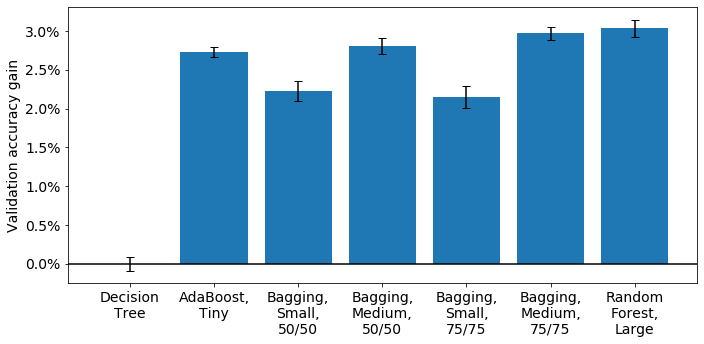

In [8]:
classifier_labels = ['Decision\nTree', 'AdaBoost,\nTiny', 
                     'Bagging,\nSmall,\n50/50', 'Bagging,\nMedium,\n50/50', 
                     'Bagging,\nSmall,\n75/75', 'Bagging,\nMedium,\n75/75', 
                     'Random\nForest,\nLarge']

baseline = 0
print("Baseline accuracy of {}: {:.5f} ± {:.5f}".format(classifier_labels[baseline].replace('\n', ' '),
      np.mean(accuracies[baseline]), np.std(accuracies[baseline])))
plot_accuracy_gain(accuracies, classifier_labels, baseline=0, fn=None, label_rotation=0)

Performance increases of ensemble over (unoptimized) Decision Tree is large.  
**Show top performing classifiers**

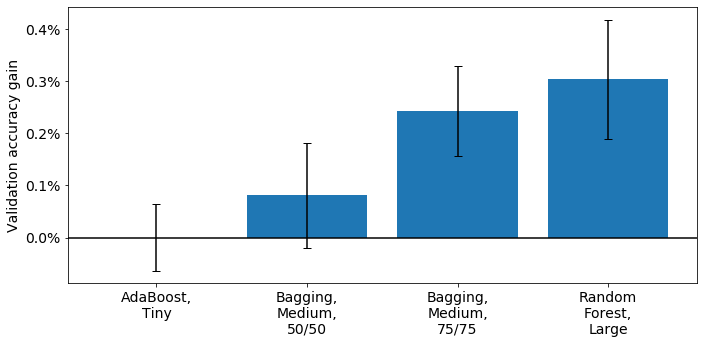

Accuracy of AdaBoost, Tiny: 0.93455 ± 0.00064
Accuracy of Bagging, Medium, 50/50: 0.93536 ± 0.00101
Accuracy of Bagging, Medium, 75/75: 0.93698 ± 0.00086
Accuracy of Random Forest, Large: 0.93759 ± 0.00115


In [9]:
selection = [1, 3, 5, 6]
labels = np.array(classifier_labels)[selection]
plot_accuracy_gain(accuracies[selection], labels, baseline=0, fn=None, label_rotation=0)
for i in selection:
    print("Accuracy of {}: {:.5f} ± {:.5f}".format(classifier_labels[i].replace('\n', ' '),
      np.mean(accuracies[i]), np.std(accuracies[i])))

## Number of estimators for Random Forest classifier

In [10]:
# read data
data, features, target = load_data('data', trans='both')

In [11]:
n_options = [10, 30, 100, 300, 1000]
cv_folds = 5
accuracies = np.zeros(shape=(len(n_options), cv_folds))
n_jobs = -1  # number of processor cores to use (-1 to utilize all cores)
verbose = 0  # verbosity of sklearn classifier (1 = verbose, 0=silent)

for i, n_estimators in enumerate(n_options):
    print("Starting {} estimators..".format(n_estimators))
    clf = RandomForestClassifier(n_estimators=n_estimators, verbose=verbose, n_jobs=n_jobs)
    # fit RF classifier with cross validation
    accuracies[i] = cross_val_score(clf, data[features].values, data[target], cv=cv_folds, 
                                    n_jobs=n_jobs, verbose=verbose)
print("Finished.")

Starting 10 estimators..
Starting 30 estimators..
Starting 100 estimators..
Starting 300 estimators..
Starting 1000 estimators..
Finished.


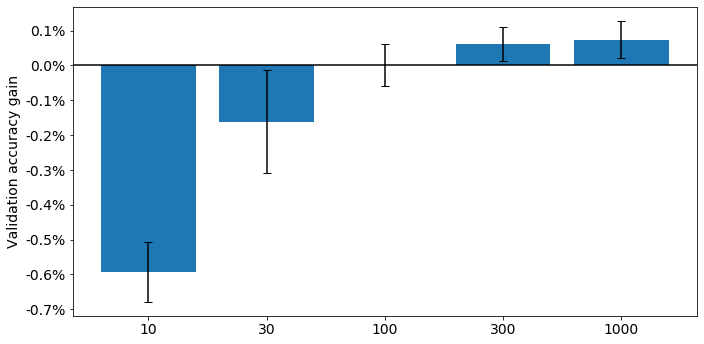

In [12]:
labels = n_options
plot_accuracy_gain(accuracies, labels, baseline=2)

**Performance of Random Forest classifier with most Decision Trees**

In [13]:
print("RF accuracy: {:.5f} ± {:.5f}".format(np.mean(accuracies[-1]), np.std(accuracies[-1])))

RF accuracy: 0.93880 ± 0.00053


## Deep Neural Network
Train a multi layered perceptron. We will start with a simple network with 128, 64 and 32 hidden nodes. 

## Read preprocessed data

In [14]:
# read train and validation data
data, features, target = load_data('data', trans='plain', norm='minmax')
train, validation = train_test_split(data, test_size=0.2, random_state=random_state)

# convert to numpy arrays
X_train, y_train = train[features].values, train[target].values
X_val, y_val = validation[features].values, validation[target].values

## Multi layered perceptron

In [15]:
args = make_args(name='DNN baseline', wandb_init=False)

id                         DNN baseline
architecture                           
loss                binary_crossentropy
activation                         relu
final_activation                sigmoid
dropout                               0
epochs                               20
batch_size                           32
lr                                0.001
lr_decay                              0
optimizer                          adam
norm                             minmax
trans                             plain
nodes1                              128
nodes2                               64
nodes3                               32
nodes4                                0
nodes5                                0
dropout1                              0
dropout2                              0
dropout3                              0
dropout4                              0
dropout5                              0
batch_norm                           []
dtype: object


Starting fold 1/5 with 80000 train samples and 20000 validation samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               17920     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 28,289
Trainable params: 28,289
Non-trainable params: 0
_________________________________________________________________


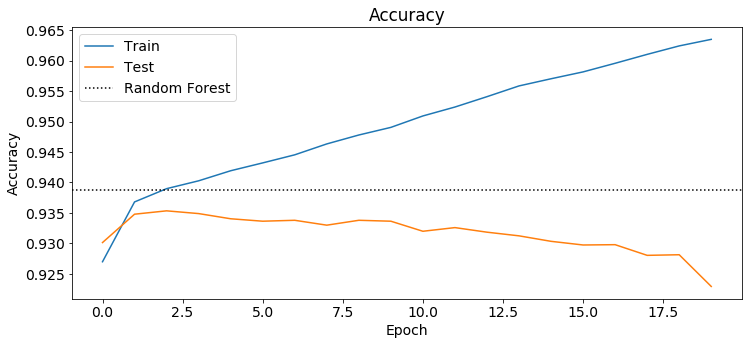

Starting fold 2/5 with 80000 train samples and 20000 validation samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               17920     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 28,289
Trainable params: 28,289
Non-trainable params: 0
_________________________________________________________________


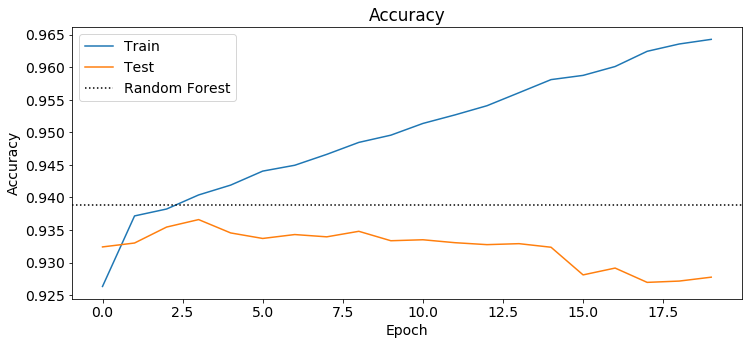

Starting fold 3/5 with 80000 train samples and 20000 validation samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               17920     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 28,289
Trainable params: 28,289
Non-trainable params: 0
_________________________________________________________________


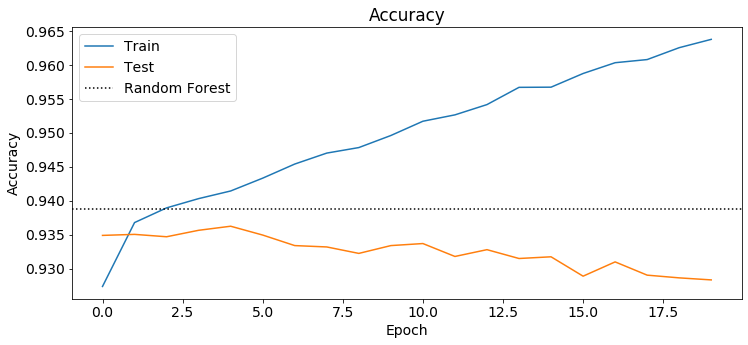

Starting fold 4/5 with 80000 train samples and 20000 validation samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               17920     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 28,289
Trainable params: 28,289
Non-trainable params: 0
_________________________________________________________________


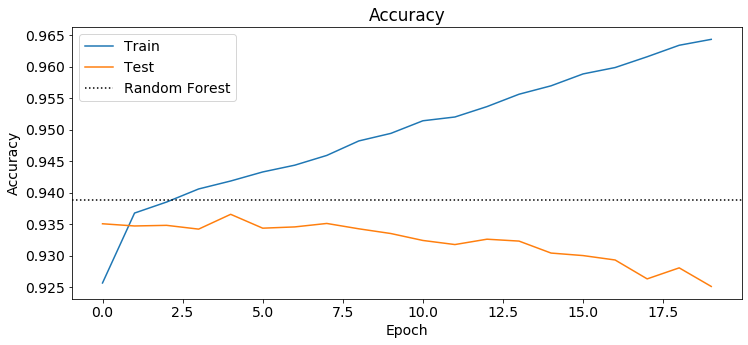

Starting fold 5/5 with 80000 train samples and 20000 validation samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               17920     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 28,289
Trainable params: 28,289
Non-trainable params: 0
_________________________________________________________________


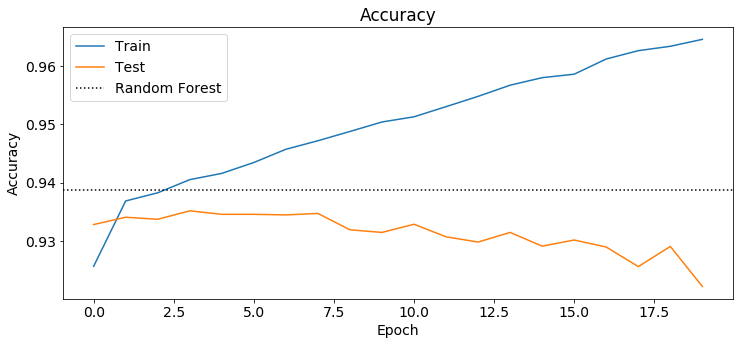

In [31]:
cv_folds = 5
dnn_accuracies = np.zeros(cv_folds)
baseline_acc = np.mean(accuracies[-1]) # or None

for i, cv_it in enumerate(range(1, 1+cv_folds)):
    # perform cross validation splits
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    # bit wacky, but this selects the cv-th set of train/test indices (with cv starting at ONE)
    for i in range(cv_it):
        train_indices, val_indices = next(kf.split(data))
    
    # define train and validation sets
    train, validation = data.iloc[train_indices], data.iloc[val_indices]
    print("Starting fold {}/{} with {} train samples and {} validation samples".format(
        cv_it, cv_folds, len(train_indices), len(val_indices)
    ))
    
    model, history = train_net(args, X_train, y_train, X_val, y_val,
                           keras_verbose=0, evaluate=False)
    
    # save accuracy
    y_pred = model.predict(X_val)
    y_pred = (y_pred > 0.5) # convert confidence to classification
    dnn_accuracies[i] = accuracy_score(y_val, y_pred)
    
    # show accuracies
    f, axes = plt.subplots(1, 1, figsize=(12, 5))
    ax = axes
    ax.plot(history.history['acc'], label='Train')
    ax.plot(history.history['val_acc'], label='Test')
    ax.set_title("Accuracy"); ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch");

    if baseline_acc is not None:
        ax.axhline(baseline_acc, linestyle=':', color='k', label='Random Forest')  # mean Random Forest accuracy

    ax.legend()
    plt.show()

In [32]:
print("DNN accuracy: {:.5f} ± {:.5f}".format(np.mean(dnn_accuracies), np.std(dnn_accuracies)))

DNN accuracy: 0.92528 ± 0.00246


The neural network performs similar to the Random Forest classifier, albeit a bit worse. So far, the Random Forest classifier performs best, with a validation accuracy just short of 94%. The dense neural network shows good potential and can probably still improve on the final validation accuracy of about 93%.  

Note that these results are only exploratory, as no optimization has been done. 

## Convolutional network
The dense network performed well, but a convolutional network can possible provide additional information. The information about the energy and type of object is probably best suited for a dense network, but a convolutional neural network can perhaps extract more information about the spatial relations.  

The exploration of the CNN is done in `Train Convolutional Neural Networks`. 